In [231]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [232]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
import os
import h5py
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid': False})

## Elijah Kane Data Science 320 Final

Introduction: 
   My question was what would be the best classifier for predicting if a tile of a picture contains a tumor from PET and CT images? This of course had several different questions that came with it. For example, can I figure out how to make a classifier? Will I be able to complete it on time, can I even get the images to display and the question I asked probably too late was can I make these into a cool visualization? Unfortunately at the end of this project I realized that I had spent 90% of the project working on machine learning techniques and not so much on visualization. But I was successful in being able to anwser my question. The data that I found contained 18 images of patients with tumors. The tumors were located throughout the patients bodies. Each patient had four images associated with them. The images were xray, CT scan, PET scan, and location of the tumor(label). 

Methods:
    1. View images (Took an embarassing amount of time)
    2. Select one paitent and 3 of the patients images to use for the classifier(CT, PET, Label)
    3. Standardize images to all have the same shape and dimmensions, remove borders, and make blurry 
    4. Divide images into tiles
    5. Split the data into test and training set
    6. Test Classifiers and Visualize
    Classifiers used:
        KNN (1 neighbor) 
        Decision Tree
        Support Vector Regression
I found after I had made the models that the data I was trying to classify was continuous not catagorical. My interpretation was that when the tiles were broken up they were on a spectrum instead of being a 1 is a tumor and 0 is not. Which resulted in the KNN being best with 1 neighbor and not being able to use a Support Vector Machine, I had to use Support Vector Regression

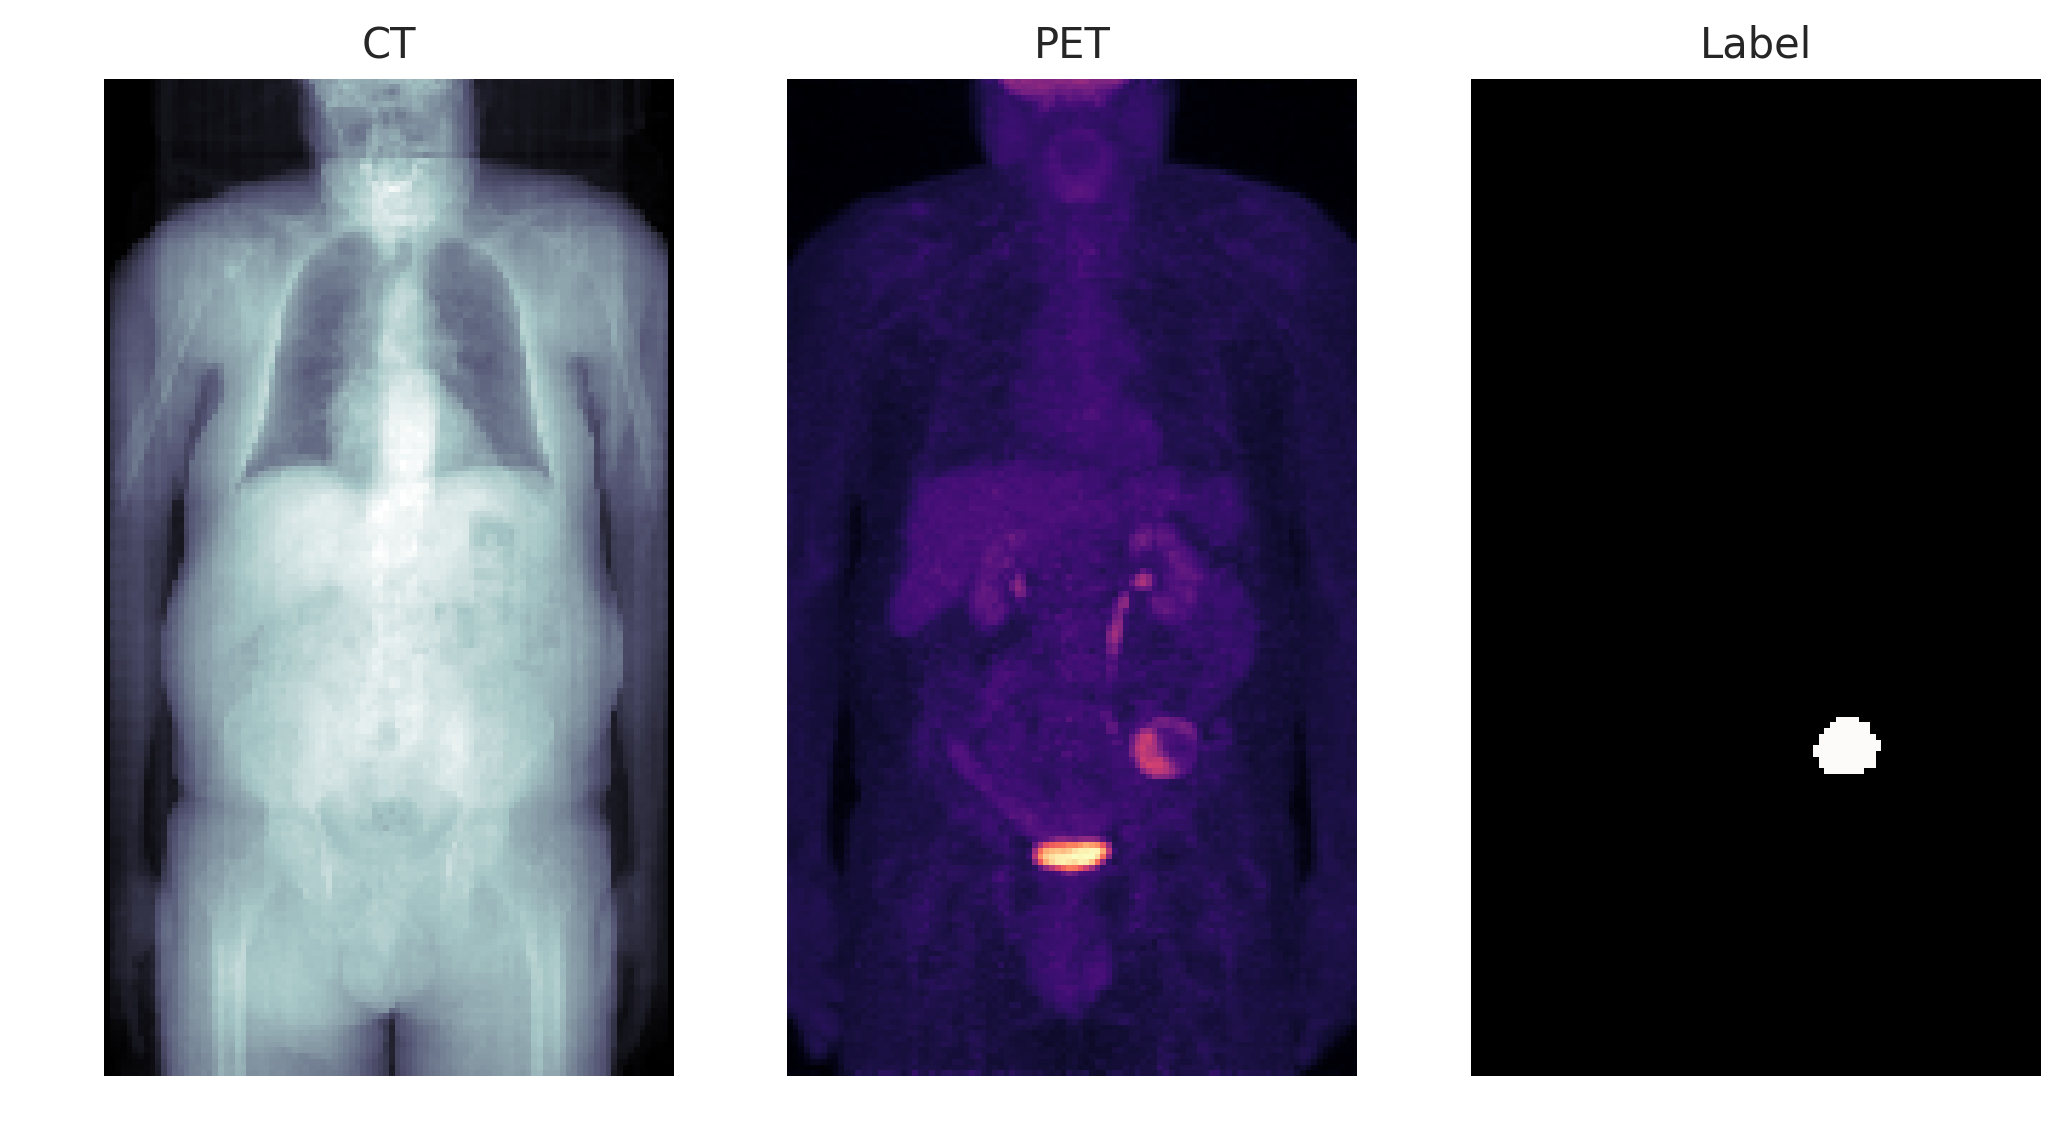

In [233]:
with h5py.File('lab_petct_vox_5.00mm.h5') as p_data:
    fig, (c_ax1, c_ax2, c_ax3) = plt.subplots(1, 3, figsize=(10, 10), dpi = 250)
    for (p_id, ct_img), pt_img, lab_img in zip(
                                   p_data['ct_data'].items(),
                                   p_data['pet_data'].values(),
                                   p_data['label_data'].values()
                                                           ):
        c_ax1.imshow(np.sum(ct_img,1).squeeze()[::-1,:], cmap = 'bone')
        c_ax1.set_title('CT')
        c_ax1.axis('off')
        
        c_ax2.imshow(np.sqrt(np.max(pt_img,1).squeeze()[::-1,:]), cmap = 'magma')
        c_ax2.set_title('PET')
        c_ax2.axis('off')
        
        c_ax3.imshow(np.max(lab_img,1).squeeze()[::-1,:], cmap = 'gist_earth')
        c_ax3.set_title('Label')
        c_ax3.axis('off')
        cur_ct_img = np.sum(ct_img,1).squeeze()[::-1,:]
        cur_pet_img = np.sum(pt_img,1).squeeze()[::-1,:]
        cur_lab_img = np.max(lab_img,1).squeeze()[::-1,:]
        break # only load the first patient

Figure 1. Three images showing from left to right( CT scan, PET scan, and Label) a tumor is shown in the left region of the patients pelvic region. 

In [234]:
ct_tiles = []
pet_tiles = []
lab_tiles = []
for i in (range(0, cur_ct_img.shape[0], 16)):
    for j in range(0, cur_ct_img.shape[1], 16):
        for i_k in range(0, 16, 3):
            for j_k in range(0, 16, 3):
                ct_tiles += [cur_ct_img[i+i_k:(i+i_k+16),j+j_k:(j+j_k+16)]]
                pet_tiles += [cur_pet_img[i+i_k:(i+i_k+16),j+j_k:(j+j_k+16)]]
                lab_tiles += [cur_lab_img[i+i_k:(i+i_k+16),j+j_k:(j+j_k+16)]]

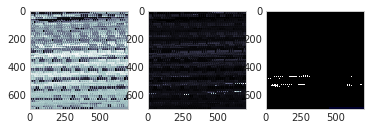

In [235]:
# remove all tiles which do not have the right size, and remove borders
n_ct_tiles = [c_tile for c_tile in ct_tiles if c_tile.shape == (16,16)]
n_pet_tiles = [c_tile for c_tile in pet_tiles if c_tile.shape == (16,16)]
n_lab_tiles = [c_tile for c_tile in lab_tiles if c_tile.shape == (16,16)]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(montage2d(np.stack(n_ct_tiles,0)), cmap = 'bone')
ax2.imshow(montage2d(np.stack(n_pet_tiles,0)), cmap = 'bone')
ax3.imshow(montage2d(np.stack(n_lab_tiles,0)), cmap = 'gist_earth')

Figure 2. Three images showing from left to right( CT scan, PET scan, and Label) after the images were reshaped and blurred.

In [236]:
lab_score = [np.mean(c_tile) for c_tile in n_lab_tiles]
ct_tile_flat = [c_tile.flatten() for c_tile in n_ct_tiles]
lab_class = [c_score > 0 for c_score in lab_score]

In [237]:
from sklearn.model_selection import train_test_split
train_tiles, test_tile, train_score, test_score = train_test_split(np.stack(ct_tile_flat), lab_score, 
                                                                   train_size = 0.75, stratify = lab_class, random_state = 1234)
#print('Training size', train_tiles.shape, 'Testing size', test_tile.shape)
#print('Train tumor tiles', np.where(train_score), 'Test tumor tiles', np.where(test_score))

/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# KNN Model

In [238]:
from sklearn.neighbors import KNeighborsRegressor
knn1_model = KNeighborsRegressor(1, algorithm = 'brute')

In [239]:
knn1_model.fit(train_tiles,train_score)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [240]:
test_predictions = knn1_model.predict(test_tile)
#print('Predicted Results', test_predictions)

In [241]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(test_score)>0, np.array(test_predictions)>0)

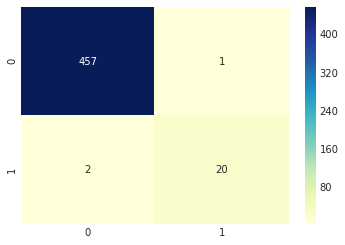

In [242]:
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")

Figure 3. The Confusion Matrix of the KNN model predicting if a tile was a tumor or not (True positive = 20, True Negative = 457, False Negative = 2, and False Positive = 1).

In [243]:
knn1_model.score(test_tile,test_score)

0.9189726500585087

The accuracy of the model was 92%. The KNN model is the most accurate so far. 

(-0.1, 1.1)

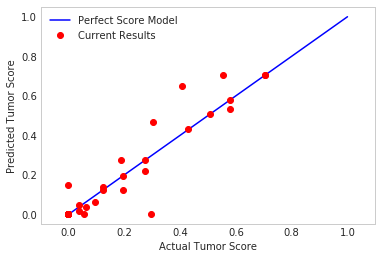

In [244]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Perfect Score Model')
ax1.plot(test_score, test_predictions, 'ro', label = 'Current Results')
ax1.set_xlabel('Actual Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)

Figure 4. Showing the Predicted Tumor Score vs Actual Tumor score for the KNN model, if the model was perfect then the model would have fit the blue line exaclty. The model has a very close clustering around the blue line.

# Decision Tree Regression

In [245]:
from sklearn.tree import DecisionTreeRegressor
tumor_tree = DecisionTreeRegressor()
tumor_tree.fit(train_tiles,train_score)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [246]:
tree_predictions = tumor_tree.predict(test_tile)

(-0.1, 1.1)

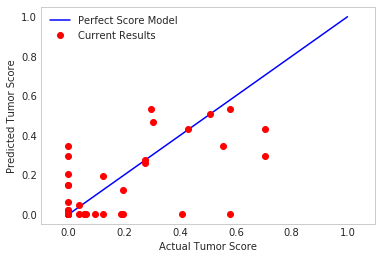

In [247]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Perfect Score Model')
ax1.plot(test_score, tree_predictions, 'ro', label = 'Current Results')
ax1.set_xlabel('Actual Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)

Figure 5. Showing the Predicted Tumor Score vs Actual Tumor score for the Decision Tree Regression model, if the model was perfect then the model would have fit the blue line exaclty. The predicted values are far from the line, a theory is that the tree over fit and wrongly predicted the tumor scores because of that.

In [248]:
cmd = confusion_matrix(np.array(test_score)>0, np.array(tree_predictions)>0)

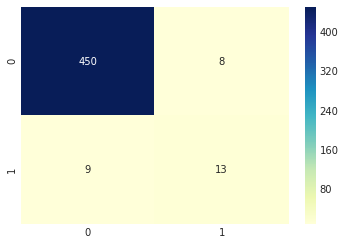

In [249]:
ax = sns.heatmap(cmd, annot=True, fmt="d",cmap="YlGnBu")

Figure 6. The Confusion Matrix of the Decision Tree Regression model predicting if a tile was a tumor or not (True positive = 14, True Negative = 453, False Negative = 8, and False Positive = 5).

In [250]:
tumor_tree.score(test_tile,test_score)

0.5688473677092496

The accuracy of the model was 49%. The Tree Regression is only roughly half as accurate as the KNN model. Current working hypothesis is that the decision tree might have overfit or some other error and misclassified more data.  

# Support Vector Regression

In [251]:
from sklearn import svm

In [252]:
clf = svm.SVR()
clf.fit(train_tiles,train_score) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [253]:
clf_predict = clf.predict(test_tile)

(-0.1, 1.1)

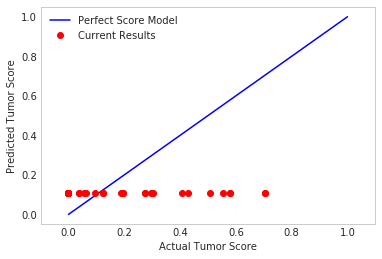

In [254]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Perfect Score Model')
ax1.plot(test_score, clf_predict, 'ro', label = 'Current Results')
ax1.set_xlabel('Actual Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)

Figure 7. Showing the Predicted Tumor Score vs Actual Tumor score for the Decision Tree Regression model, if the model was perfect then the model would have fit the blue line exaclty. The predicted values are a line of their own.

In [255]:
clf.score(test_tile,test_score)

-1.3788060638503572

Yeah I'm not sure what to do. What I did was use the SVR command becasue the SVM wouldn't take my data because it wasn't catagorical. My data was continuous so I wanted to be able to use a Support Vector something and I figured the regression would work and it kinda did. So the data was fit to a linear regression line instead of a scatter plot type thing. But the confusion matrix is quite interesting and helps explain the negative value. 

In [256]:
clfmat = confusion_matrix(np.array(test_score)>0, np.array(clf_predict)>0)

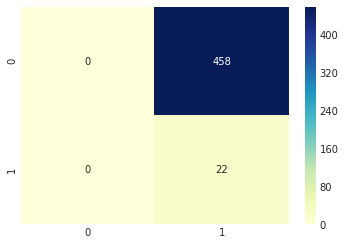

In [257]:
ax = sns.heatmap(clfmat, annot=True, fmt="d",cmap="YlGnBu")

Figure 8. The Confusion Matrix of the Decision Tree Regression model predicting if a tile was a tumor or not (True positive = 22, True Negative = 0, False Negative = 0, and False Positive = 458).

The confusion matrix shows that the model predicted every tile to be positive. As is shown that there are no negative predictions at all. The model did guess all the tumor tiles were tumor tiles though, which was better than the other two models. 

My question was what would be the best classifier for predicting if a tile of a picture contains a tumor from PET and CT images? The best classifier was the KNN of the three that I chose. I was also able to anwser my sub questions also by saying that I was able to get this far. For future projects it would be super interesting to see if you would be able to compare which image was better at predicting using the KNN model. My guess would be the PET scan but I really don't know. I hope this project gives you some amusement and as always, Thanks Professor. 